In [407]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [408]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in [0, 4]:
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

20

In [409]:
images = []
for sample_idx in samples_idx.flatten():
    images.append(mndata.train_images[sample_idx])

images = np.array(images, dtype='float')
images = images / 255
images.shape

(20, 784)

In [410]:
def simple_plot(T: list):
    T_arr = np.array(T, dtype=float)

    fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
    axs.plot(np.arange(T_arr.size), T_arr)


    plt.show()

In [411]:
from typing import Literal

def show_image(image: ndarray, is_figsize = False, cmap: Literal['bone', 'Greys'] = 'bone'):
    if is_figsize:
        figure(figsize=(15, 1))

    aspect = 'equal'
    if is_figsize:
        aspect = 'auto'

    imshow(np.array(image),
        interpolation='none',
        aspect=aspect,
        cmap=cmap,
        )

    axis("off")

    show()

In [412]:
def get_discount_matrix(size, rev = False, cor_supr_size=0):
    a = np.arange(size)
    if rev:
        a = np.abs(np.abs(a - a[np.newaxis].T) - np.max(a))
    else:
        a = np.abs(a - a[np.newaxis].T)
    np.fill_diagonal(a, 0)

    if cor_supr_size > 0:
        a[:cor_supr_size] = 0
        a[:, 0:cor_supr_size] = 0
        a[-cor_supr_size:] = 0
        a[:, -cor_supr_size:] = 0

    return a

# a = get_discount_matrix(10, rev=True, cor_supr_size=2)
# a = np.array(a, dtype='float')
# # a[:, 0:2] = 0
# print(a)
# show_image(a, cmap='Greys')

In [413]:
def show_images_table(images_2d: ndarray, img_side: int = 28, row_size=10):
    column_size = int(images.shape[0] / row_size)

    shaped_images = images_2d.reshape(column_size, row_size, img_side, img_side)
    shaped_images = shaped_images.swapaxes(1, 2).reshape(column_size*img_side, row_size*img_side)

    figure(figsize=(15, 10))

    imshow(shaped_images,
           interpolation='none',
           aspect='equal',
           cmap='bone',
           )
    
    axis("off")

# show_images_table(images_2d=images)
images.shape

(20, 784)

In [414]:
I = np.zeros(n_mnist_pixels)
O1 = np.zeros(n_mnist_pixels)
O2 = np.zeros(1024)

# W = np.random.rand(O.size, I.size) - 0.5
IW = np.random.normal(0, 0.1, (O2.size, O1.size))
LW = np.random.normal(0, 0.1, (O2.size, O2.size))
print(LW.max(), LW.min())

prec = 1e-30

train_images_idx = [0, 10]

eps0 = 0.01

epoch_cnt = 100

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    img_out = []

    for img_idx in train_images_idx:
        I = images[img_idx]

        O1.fill(0)
        O2.fill(0)

        out = []

        last_iter = 0

        PO1 = np.zeros(O1.size)
        PO2 = np.zeros(O2.size)
        
        for iter_idx in range(100):
            # show_image(image=I.reshape(img_side, img_side))

            # infer O1
            dO1 = np.dot(IW.T, O2)
            dO1 /= np.max(np.abs(dO1)) + prec

            dO1 += I
            O1 += dO1

            O1 *= (O1 > 0)

            O1 /= np.max(O1) + prec

            # infer O2
            dO2 = np.dot(IW, O1)
            dO2 /= np.max(np.abs(dO2)) + prec

            dLO2 = np.dot(PO2, LW)
            dLO2 /= np.max(np.abs(dLO2)) + prec

            O2 += dO2
            O2 += dLO2
            O2 += np.random.rand(O2.size) * 0.1

            O2 *= (O2 > 0)

            O2 /= np.max(O2) + prec

            # prev
            prev_diff = np.abs(PO1 - O1).sum()
            # prev_diff = np.abs(PO2 - O2).sum()

            out.append(prev_diff)
            
            last_iter += 1

            if prev_diff < 0:
                break

            # recur
            PO1 = np.copy(O1)
            PO2 = np.copy(O2)

        # train O1
        dIWT = O2 - IW.T * O1[np.newaxis].T
        dIWT /= np.max(np.abs(dIWT)) + prec

        # train O2
        dIW = O1 - IW * O2[np.newaxis].T
        dIW /= np.max(np.abs(dIW)) + prec

        dLW = PO2 - LW * O2[np.newaxis].T
        dLW /= np.max(np.abs(dLW)) + prec

        # update
        dIW += dIWT.T
        IW += dIW * eps
        
        LW += dLW * eps

        # stats
        img_out.append(np.copy(O2))

        # simple_plot(T=out)
        # show_image(image=O2[np.newaxis], is_figsize=True)
        # show_image(image=O1.reshape(img_side, img_side))
        print(f'{last_iter=}')
        print(f'{(O1 > 0).sum()=}')
        print(f'{(O2 > 0).sum()=}')

    # diff = np.abs(img_out[0] - img_out[1]).sum()
    # print(f'{diff=}')

0.46318552073800445 -0.464523667660107
last_iter=100
(O1 > 0).sum()=474
(O2 > 0).sum()=576
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_iter=100
(O1 > 0).sum()=784
(O2 > 0).sum()=1024
last_ite

In [415]:
out_arr = np.array(out)
print(out_arr.min(), out_arr[-1])

# show_image(image=img_out[-1].reshape(img_side, img_side))

2.6645352591003757e-15 9.536815781530095e-14


In [416]:
def infer(img: ndarray, IW: ndarray, LW: ndarray, inter_cnt = 100):
    I = np.copy(img)

    O1 = np.zeros(IW.shape[1])
    O2 = np.zeros(IW.shape[0])

    out = []

    last_iter = 0

    PO1 = np.zeros(O1.size)
    PO2 = np.zeros(O2.size)
    
    for iter_idx in range(inter_cnt):
        # infer O1
        if iter_idx == 0:
            dO1 = I
        else:    
            dO1 = np.dot(IW.T, O2)
            dO1 /= np.max(np.abs(dO1)) + prec
        
        O1 += dO1

        O1 *= (O1 > 0)

        O1 /= np.max(O1) + prec

        # infer O2
        dO2 = np.dot(IW, O1)
        dO2 /= np.max(np.abs(dO2)) + prec

        dLO2 = np.dot(PO2, LW)
        dLO2 /= np.max(np.abs(dLO2)) + prec

        O2 += dO2
        O2 += dLO2
        # O2 += np.random.rand(O2.size)

        O2 *= (O2 > 0)

        O2 /= np.max(O2) + prec

        # prev
        prev_diff = np.abs(PO1 - O1).sum()
        # prev_diff += np.abs(PO2 - O2).sum()

        out.append(prev_diff)
        
        last_iter += 1

        if prev_diff < 0:
            break

        # recur
        PO1 = np.copy(O1)
        PO2 = np.copy(O2)

    return out, last_iter, O1, O2

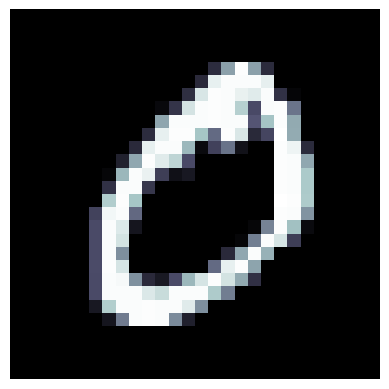

ifr_last_iter=100
(ifr_O1 > 0).sum()=784
(ifr_O2 > 0).sum()=1024


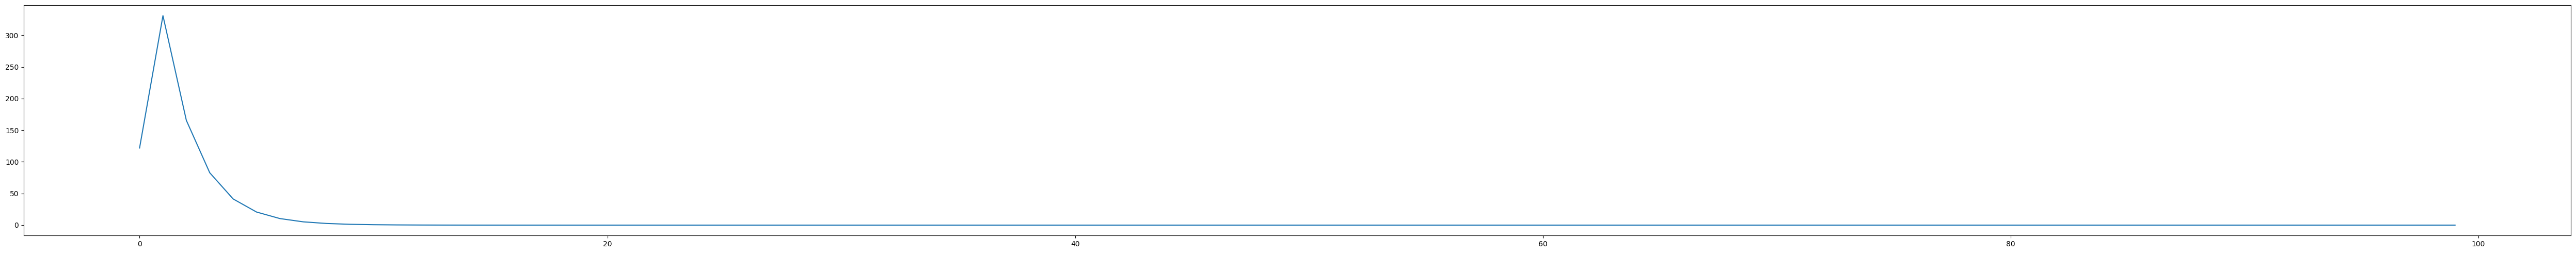

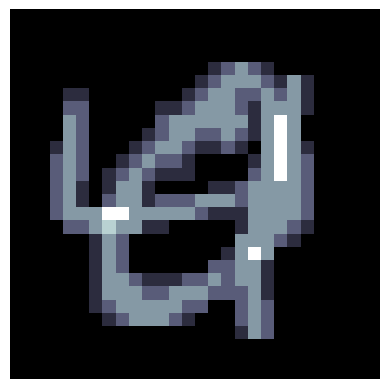

In [417]:
img_idx = 0
show_image(image=images[img_idx].reshape(img_side, img_side))

ifr_out, ifr_last_iter, ifr_O1, ifr_O2 = infer(img=images[img_idx], IW=IW, LW=LW)

print(f'{ifr_last_iter=}')
print(f'{(ifr_O1 > 0).sum()=}')
print(f'{(ifr_O2 > 0).sum()=}')

simple_plot(T=ifr_out)

show_image(image=ifr_O1.reshape(img_side, img_side))

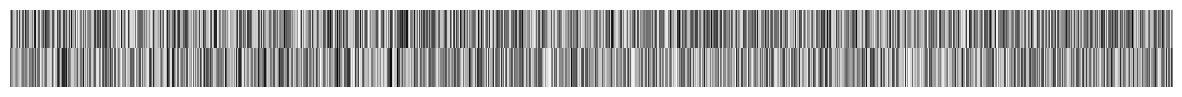

In [418]:
diff_img_arr = np.array([img_out[0], img_out[1]])
figure(figsize=(15, 1))

imshow(np.array(diff_img_arr),
       interpolation='none',
       aspect='auto',
       cmap='Greys',
       )

axis("off")

show()